In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')



MessageError: Error: credential propagation was unsuccessful

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import files
import io

from google.colab import files
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# uploaded = files.upload()

# data = pd.read_csv('gdrive/MyDrive/Deep Learning/Game_of_Thrones_Script/Game_of_Thrones_Script.csv')
data = pd.read_csv("/Game_of_Thrones_Script.csv")

data = data.drop(columns=['Release Date', 'Season', 'Episode', 'Episode Title', 'Name'])
sentences = data['Sentence']

sentences = sentences.dropna()

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
input_sequences = [tokenizer.encode(s, add_special_tokens=True) for s in sentences]

sentence_lengths = [len(tokenizer.encode(s, add_special_tokens=True)) for s in sentences]
max_sequence_len = 52
# max_sequence_len = int(np.percentile(sentence_lengths, 95))

# max_sequence_len = max([len(seq) for seq in input_sequences])

x = [seq[:-1] for seq in input_sequences]
y = [seq[1:] for seq in input_sequences]

x = pad_sequences(x, maxlen= max_sequence_len-1, padding='pre')
y = pad_sequences(y, maxlen= max_sequence_len-1, padding='pre')

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=123)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=123)

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis= -1)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]

        query = self.split_heads(self.wq(query), batch_size)
        key = self.split_heads(self.wk(key), batch_size)
        value = self.split_heads(self.wv(value), batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

def positional_encoding(position, d_model):
        angle_rads = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        angle_rads[:, 0::2] = np.sin(position * angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(position * angle_rads[:, 1::2]) # diganti jadi cos karena odd -> sesuai rumus
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = len(tokenizer.vocab)
maximum_position_encoding = max_sequence_len
dropout_rate = 0.3

inputs = tf.keras.layers.Input(shape= (max_sequence_len-1, ))

x = tf.keras.layers.Embedding(input_vocab_size, d_model)(inputs)
x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
x += positional_encoding(maximum_position_encoding, d_model)

x = tf.keras.layers.Dropout(dropout_rate)(x)

for _ in range(num_layers):

    attn_output, _ = MultiHeadAttention(d_model, num_heads)(x, x, x, None)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    ff_output = point_wise_feed_forward_network(d_model, dff)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

outputs = tf.keras.layers.Dense(input_vocab_size, activation='softmax')(x)
transformer = tf.keras.Model(inputs=inputs, outputs= outputs)

transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
transformer.summary()

epochs = 20
batch_size = 8

print(max_sequence_len)

history = transformer.fit(x_train,
                          np.expand_dims(y_train, -1),
                          validation_data=(x_val, np.expand_dims(y_val, -1)),
                          epochs= epochs, batch_size= batch_size)

loss, accuracy = transformer.evaluate(x_test, np.expand_dims(y_test, -1))
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

plt.figure(figsize=(18, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)  # Use the second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig("Self Supervised Learning Accuracy and Loss Graph.png")
plt.show()
files.download("Self Supervised Learning Accuracy and Loss Graph.png")


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 51, 128)              3711488   ['input_5[0][0]']             
                                                                                                  
 tf.math.multiply_4 (TFOpLa  (None, 51, 128)              0         ['embedding_4[0][0]']         
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_20 (T  (None, 51, 128)              0         ['tf.math.multiply_4[0][

KeyboardInterrupt: 

In [ ]:
sentences = sentences.dropna()
sentences.isnull().values.any()


False

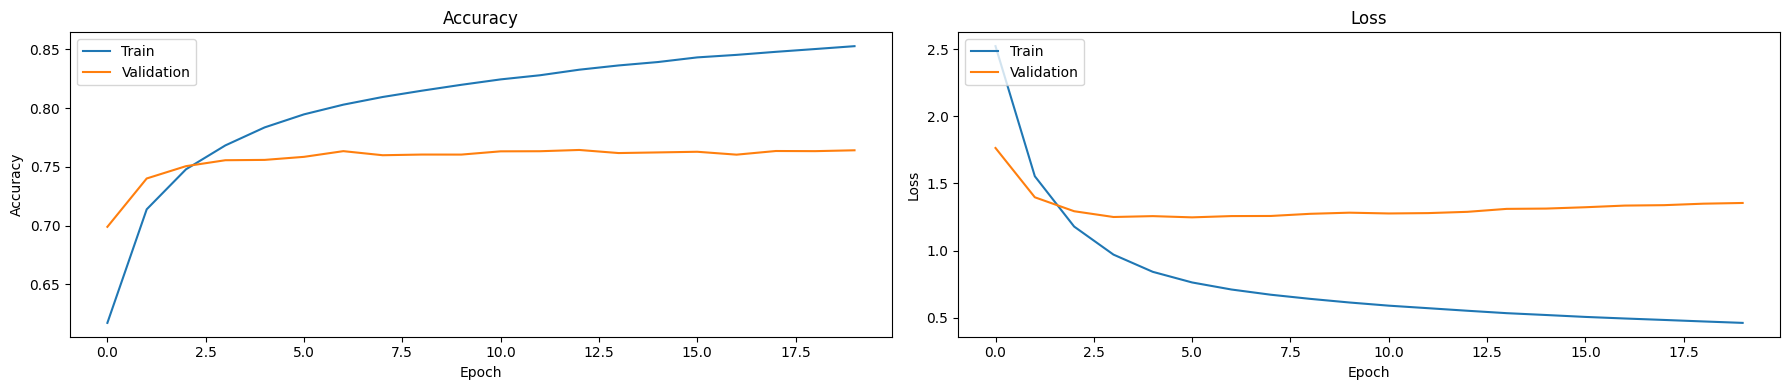

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(18, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)  # Use the second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig("Self Supervised Learning Accuracy and Loss Graph.png")
plt.show()
files.download("Self Supervised Learning Accuracy and Loss Graph.png")


In [ ]:
transformer.save("transformer_model.h5")
files.download("transformer_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def predict_next_token(model, tokenizer, text):
    encoded_input = tokenizer.encode(text, add_special_tokens=True)
    padded_input = pad_sequences([encoded_input], maxlen=max_sequence_len-1, padding='pre')

    prediction = model.predict(padded_input)
    last_token_prediction = prediction[0, -1, :]
    predicted_index = np.argmax(last_token_prediction)

    return tokenizer.decode([predicted_index])

predicted_token = predict_next_token(transformer, tokenizer, sentence)
print(f"Predicted Next Tokens: {predicted_token}")


1/1 [==============================] - 0s 43ms/step
Predicted Next Tokens: ##fo


In [ ]:
# Lord of the Seven Kingdoms and protector of the realm, I, Eddard of the House Stark, Lord of Winterfell and Warden of the North, sentence you to
# My brother instructs us to stage a tournament in honor of Lord Stark's appointment as Hand of the King.
# I'll have to borrow it. The Lannisters will accommodate, I expect. We already owe Lord Tywin 3 million gold. What's another 80,000?
# Syrio says every hurt is a lesson and every lesson makes you better. Tomorrow I'm going to be chasing cats.
# As the sun dipped below the horizon, casting hues of orange and pink across the sky, she couldn't help but feel a sense of tranquility wash over her, as if all her worries had been swept away by the gentle embrace of
sentence = "The old mansion stood tall and imposing, its ivy-covered walls whispering tales of forgotten secrets and lost treasures, beckoning adventurous souls to explore its shadowy corridors and unravel the mysteries of the"


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import io

from google.colab import files
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# uploaded = files.upload()

# data = pd.read_csv('gdrive/MyDrive/Deep Learning/Game_of_Thrones_Script/Game_of_Thrones_Script.csv')
# data = pd.read_csv(io.StringIO(uploaded["Game_of_Thrones_Script.csv"].decode('utf-8')))
data = pd.read_csv("/Game_of_Thrones_Script.csv")
data = data.drop(columns=['Release Date', 'Season', 'Episode', 'Episode Title', 'Name'])
sentences = data['Sentence']

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

sentence_lengths = [len(tokenizer.encode(s, add_special_tokens=True)) for s in sentences]
max_sequence_len = np.percentile(sentence_lengths, 95)
print(max_sequence_len)

plt.hist(sentence_lengths, bins=30)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Sentence Lengths')
plt.show()